<a href="https://colab.research.google.com/github/luisArthurRodriguesDaSilva/estudo-dados-eleicoes/blob/master/testeBackup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 | importações de bibliotecas e recursos

In [1]:
import pandas as pd
import numpy as np
import requests
import pprint
from matplotlib import pyplot as plt
import seaborn as sns
import cmath
import threading
import time
import json
import statistics

# 2 | funções para fazer as devidas requisições na api

In [2]:
def getDeputadoEstadualUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0007-e000546-r.json'

def getPresidentUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/544/dados-simplificados/{uf}/{uf}-c0001-e000544-r.json'

def getGovernadorUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0003-e000546-r.json'

def getDeputadoFederalUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0006-e000546-r.json'

def getSenadorUrl(uf):
  return f'https://resultados.tse.jus.br/oficial/ele2022/546/dados-simplificados/{uf}/{uf}-c0005-e000546-r.json'

gets= [getPresidentUrl, getSenadorUrl, getDeputadoFederalUrl, getDeputadoEstadualUrl, getGovernadorUrl]
categoryKeys= ['Presidente', 'Senador', 'DeputadoFederal', 'DeputadoEstadual', 'Governador']
brasil_ufs = ['ac','al','am','ap','ba','ce','df','es','go','ma','mt','ms','mg','pa','pb','pr','pe','pi','rj','rn','ro','rs','rr','sc','se','sp','to']

LULA_TAG          = 'LULA' 
BOLSONARO_TAG     = 'JAIR BOLSONARO' 
CIRO_TAG          = 'CIRO GOMES' 
TEBET_TAG         = 'SIMONE TEBET' 
SORAYA_TAG        = 'SORAYA THRONICKE' 
DAVILA_TAG        =  "FELIPE D'AVILA"
PADRE_TAG         = 'PADRE KELMON' 
SOFIA_MANZANO_TAG = 'SOFIA MANZANO' 
LEO_PERICLES_TAG  ='LÉO PÉRICLES'
VERA_TAG          = 'VERA' 
EYMAEL_TAG        = 'CONSTITUINTE EYMAEL'
candidatesTags    = [LULA_TAG, BOLSONARO_TAG, CIRO_TAG, TEBET_TAG, SORAYA_TAG, DAVILA_TAG, PADRE_TAG, SOFIA_MANZANO_TAG, LEO_PERICLES_TAG, VERA_TAG, EYMAEL_TAG]
candidatesColors   =['red', 'green', 'blue','brown', 'green', 'blue','red', 'green', 'blue','green','yellow']
politicalColors = {}
for i, tag in enumerate(candidatesTags):
  politicalColors[tag] = candidatesColors[i]

# 3 | Funções para a coleta de **dados**

In [3]:
arq =r'/content/drive/MyDrive/completeUfsNames.json'
with open(arq,'r') as f:
  completeUfsNames = json.load(f)[0]

In [4]:
def getPopulationByUf(uf,info = 'População (2021)'):
  url = 'https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o'
  table = pd.read_html(url , match='Posição')
  ufs_population_data = table[0]
  region_population_data = table[1]
  ufName = completeUfsNames[uf.upper()]
  keysArray = list(ufs_population_data.keys()[0:].array)
  positionOfInfo = keysArray.index(info)
  usedData = ufs_population_data.values
  try:
    filteredUsedData = list(filter( lambda x: x[1] == ufName, usedData))[0]
  except Exception as e:
    return 'não encontrado'
  requiredInfo = str(filteredUsedData[positionOfInfo])
  return int(requiredInfo.replace(u'\xa0', ''))

def getPibByUf(uf, info= 'PIB em 2019 (1.000.000 R$)'):
  url = 'https://www.ibge.gov.br/explica/pib.php'
  table = pd.read_html(url , match='Unidades da Federação')
  pibsData = table[0]
  ufName = completeUfsNames[uf.upper()]
  try:
    filteredUsedData = list(filter(lambda x: x[0] == ufName ,pibsData.values))[0][1]
  except Exception as e:
    return 'não encontrado'
  requiredInfo = str(filteredUsedData.replace('.',''))
  return int(requiredInfo)

def getPibPerCapta(uf):
  return float(abs(getPibByUf(uf) / getPopulationByUf(uf)))

In [5]:
def takeData(url):
  re=requests.get(url).json()
  candidatos = re['cand']

  df=pd.DataFrame(candidatos)
  df=df[['nm','n','dvt','vap','pvap']]
  df.rename(columns={'nm':'Nome do Candidato',
                  'n':'Numero do Candidato',
                  'dvt':'Validade',
                  'vap':'Votos',
                  'pvap':'(%) Votos'}, inplace=True)
  
  df['(%) Votos']=df['(%) Votos'].str.replace(',','.')
  df['(%) Votos']=df['(%) Votos'].astype(float)
  df['Votos']=df['Votos'].astype(int)
  df['Nome do Candidato']=df['Nome do Candidato'].str.replace('D&apos;',"D'")
  df=df.sort_values(by='Votos', ascending=False)
  return(df)

In [6]:
def getAllDataByUf(uf):
  info = {}
  for index, category in enumerate(categoryKeys):
    try:
      info[category] = takeData(gets[index](uf))
      info['populacao'] = getPopulationByUf(uf) #deve sair do loop pra n ser sobrescrito varias vezes
      info['pib'] = getPibByUf(uf)
      info['pib per-capta'] = getPibPerCapta(uf)
    except:
      if uf == 'df':
        info[category] = 'df não tem prefeito'
      else:
        info[category] = 'this is brasil'
  return info

# 4 | Organização dos dados através do electionsData
### ele é um objeto mais organizado contendo todas as informações separadas por estado

In [7]:
electionsData = {}
electionsData['br'] = getAllDataByUf('br')

def atribute(uf):
  electionsData[uf] = getAllDataByUf(uf)

for i, uf in  enumerate(brasil_ufs):
  threading.Thread(target=atribute, args=(uf,)).start()
time.sleep(5)

# 5 | Funções para exibição das informações desejadas

In [8]:
def getCandidateScore(uf,candidate, category, attr):
  keysArray = list(electionsData[uf][category].keys()[0:5].array)
  positionOtAttr = keysArray.index(attr)
  usedData = electionsData[uf][category].values
  candidateScore = list(filter(lambda x: x[0]== candidate,usedData))[0][positionOtAttr]
  return candidateScore

In [9]:
def getDiffBetweenTwoCandidates(uf, category='Presidente', candidates=[BOLSONARO_TAG , LULA_TAG], attr = '(%) Votos'):
  [candidateOne,candidateTwo] = candidates
  candidateOneScore = getCandidateScore(uf=uf,candidate= candidateOne, attr= attr,category=category )
  candidateTwoScore = getCandidateScore(uf=uf,candidate= candidateTwo, attr= attr,category=category )
  result = float(format(abs(candidateOneScore - candidateTwoScore),'.2f'))
  winer = candidateOne if candidateOneScore > candidateTwoScore else candidateTwo
  return result , winer

In [10]:
BIG_NUMBER = 9999999999
def separeDiferents(uf, usedFunc, candidates):
  acrecimo = 0 if usedFunc(uf)[1] ==  candidates[0] else BIG_NUMBER
  return usedFunc(uf)[0] + acrecimo

>função para gerar os graficos comparativos entre os candidatos de maneira genérica, dependendo apenas dos parametros

In [11]:
def showDiffPerState(candidates, attr,category= 'Presidente',mode = 0, aditionalFuncs = [],ordenator='none'):
  usedFunc = lambda uf :  getDiffBetweenTwoCandidates(uf=uf,candidates=candidates, category=category, attr=attr)
  
  if mode == 0 :
    title = f'diferença entre {candidates[0]} e {candidates[1]} por estado no país'
    ordened_ufs = sorted(brasil_ufs,key=lambda uf: usedFunc(uf)[0])
  else:
    if mode == 1 :
      title = f'diferença entre {candidates[0]} e {candidates[1]} por estado no país separadamente'
      ordened_ufs = sorted(brasil_ufs,key=lambda uf: separeDiferents(uf=uf, usedFunc=usedFunc, candidates=candidates))
    else:
      title = f'diferença entre {candidates[0]} e {candidates[1]} por estado no país ordenados por {ordenator}'
      ordened_ufs = sorted(brasil_ufs,key=lambda uf: electionsData[uf][ordenator])

  [c1Color, c2color] = [politicalColors[candidates[0]],politicalColors[candidates[1]]]
  baseOrder = (list(map(lambda uf : usedFunc(uf)[0],ordened_ufs)))
  
  ylb = attr
  if attr == 'Votos':
    ylb = 'M votos'
    counts = (list(map(lambda x : float(format(abs(x/1000000),'.2f')),baseOrder)))
  else:
    counts = baseOrder
  bar_colors = list(map(lambda uf : f'tab:{c1Color}' if usedFunc(uf)[1] == candidates[0] else f'tab:{c2color}',ordened_ufs))

  fig, ax = plt.subplots()

  for func in aditionalFuncs:
    func(ax=ax,ordened_ufs=ordened_ufs)

  ax.bar(ordened_ufs, counts, color = bar_colors)
  ax.bar([0], [0], color = c1Color, label=f'onde {candidates[0]} ganhou') #metodo para conseguir colocar a legenda
  ax.bar([0 ],[0 ], color = c2color, label=f'onde {candidates[1]} ganhou')
  fig.set_size_inches(16,8)
  ax.set_ylabel(ylb)
  ax.set_xlabel('estados')
  ax.set_title(title)
  ax.legend()
  plt.rcParams.update({'font.size': 15})
  return plt.show

def populacao(ax,ordened_ufs):
  counts = list(map(lambda uf: electionsData[uf]['populacao']/1500000,ordened_ufs))
  ax.bar([0 ],[0 ], color = 'blue', label=f'população 1.5M')
  ax.plot(ordened_ufs,counts, color = 'blue')

def pib(ax,ordened_ufs):
  counts = list(map(lambda uf: electionsData[uf]['pib']/100000,ordened_ufs))
  ax.bar([0 ],[0 ], color = 'orange', label=f'PIB (100000M R$)')
  ax.plot(ordened_ufs,counts, color = 'orange')

def pibPerCapta(ax,ordened_ufs):
  counts = list(map(lambda uf: electionsData[uf]['pib per-capta']*1000,ordened_ufs))
  ax.bar([0 ],[0 ], color = 'purple', label=f'pib per-capta parcial (1000 R$)')
  ax.plot(ordened_ufs,counts, color = 'purple')

def media(ax,ordened_ufs):
  pibsPerCapta = list(map(lambda uf: electionsData[uf]['pib per-capta']*1000,ordened_ufs))
  media = statistics.mean(pibsPerCapta)
  counts = list(map(lambda uf: media,ordened_ufs))
  ax.bar([0 ],[0 ], color = 'cyan', label=f'media per capta')
  ax.plot(ordened_ufs,counts, color = 'cyan')

def verticalLine(ax,ordened_ufs):
  ax.axvline(x = 'mg', color = 'black', label = 'divisão acima/abaixo da média')
 


#6 | Os Graficos Começam daqui pra baixo

A seguir está o grafico da diferença entre os candidatos (em porcentagem por cada região)

Podemos perceber a liderança do Píaui e Roraima respectivamente como o mais "lulistas" e "bolsonaristas" do país, entretanto a quantidade numérica de votos não expressa o mesmo

<function matplotlib.pyplot.show(*args, **kw)>

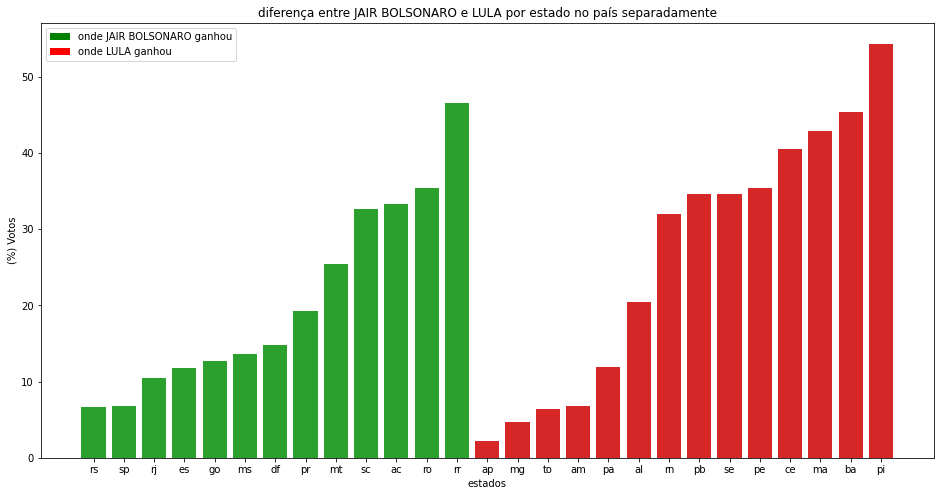

In [15]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='(%) Votos',mode = 1)

Aqui podemos perceber que a expressividade proporcional do gráfico anterior engana

>Píaui (PI), mesmo sendo o que tem mais "lulistas" proporcionalmente, não foi o que conseguiu mais votos para lula, e sim a Bahia, que teve o segundo lugar nesse quesito

>São Paulo (SP) torna essa diferença ainda mais nitida, proporcionalmente ele é o segundo **menos** bolsonarista, mas é o que conseguiu mais voto para o candidato

<function matplotlib.pyplot.show(*args, **kw)>

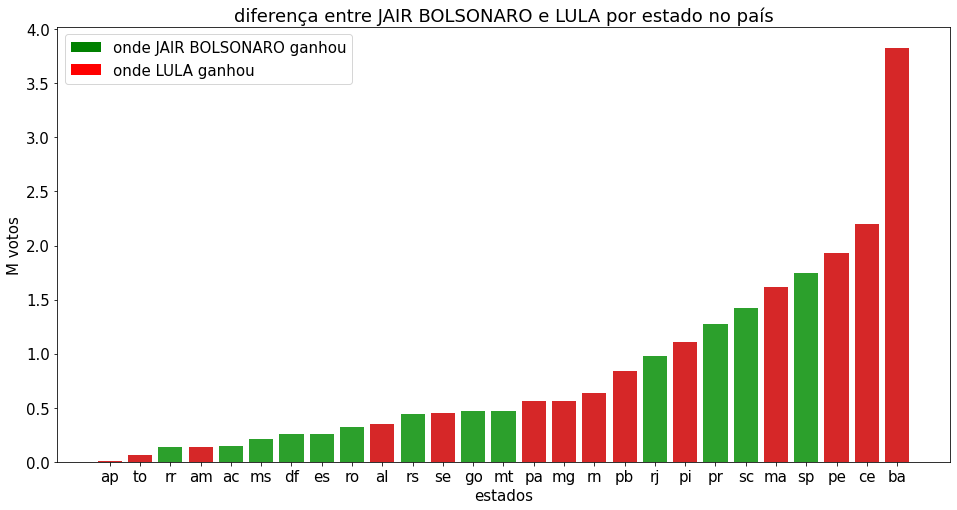

In [16]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='Votos',mode = 0)

visto que uma população suficientemente grande pode ultrapassar uma menor em numeros de votos, mesmo tendo poucos pontos percentuais contra uma grande vantagem, percebe-se que basta uma nação grande e decidida o suficiente para ofuscar grande parte dos estados menores e praticamente decidir a eleição

> entretanto, parece que algo impede isso como visto no grafico abaixo

In [ ]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='(%) Votos',mode = 1, aditionalFuncs=[populacao])

>O grafico acima nos mostra que quanto maior é a população, maior a tendencia dela a um extremo

>Isso se assemelha a situação dos mercados de ações em que quanto menor o volume/valor de mercado maior é a volatilidade do ativo

>Aparentemente um maior número de pessoas/agentes funciona como um freio, onde quanto mais pessoas, mais difícil é de ordenar-las em uma mesma direção

Agora o segundo problema é, porque que esses respectivos estados preferem o Bolsonaro enquanto os outros o Lula, Será que há um dado numérico, que possa caracterizar o porque de um ser lulista e o outro não?

Abaixo a comparação entre estados através do Pib (2019) e do pib per capta parcial ( Pib de 2019 / população de 2021 )

In [ ]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='(%) Votos',mode = 1, aditionalFuncs=[pib,pibPerCapta, media, populacao])

In [ ]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='(%) Votos',mode = 3, aditionalFuncs=[media,pibPerCapta,verticalLine], ordenator='pib per-capta')

## Aparentemente não há uma simples relação direta entre o quão bolsonarista/lulista um estado é de acordo com o seu respectivo Pib per capta, porém duas coisas podem ser constatadas

### 1 - Quanto menor o pib per capta, maior é a **probabilidade** de preferencia ao Lula, visto que dos 17 estados abaixo da média, ele venceu em 13, o mesmo para Bolsonaro, que venceu em 9 entre os 10 que estavam acima da média brasileira

### 2 - Assim como a população, quanto menor o pib per capta maior é a tendencia ao extremismo, visto que os 10 estados mais extremistas estão com o seu pib abaixo da média brasileira

>abaixo o gráfico das diferenças ordenadospelo extremismo


<function matplotlib.pyplot.show(*args, **kw)>

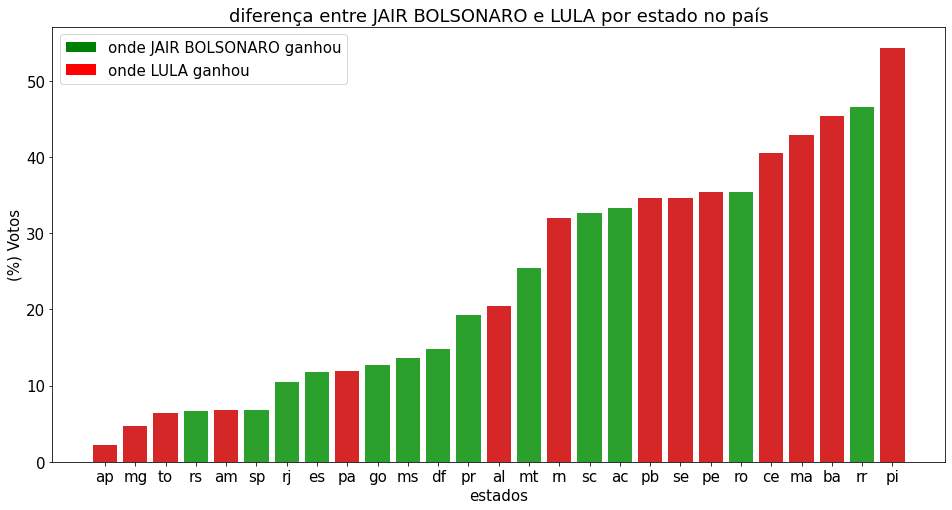

In [17]:
showDiffPerState(candidates = [BOLSONARO_TAG,LULA_TAG], attr='(%) Votos',mode = 0)

In [18]:
import pickle as pike

with open('/content/drive/MyDrive/electionsData.pkl','wb') as f:
  pike.dump(electionsData,f)

In [20]:
path = '/content/drive/MyDrive/electionsData.pkl'
with open(path,'rb') as f:
  print(pike.load(f))

{'br': {'Presidente': 'this is brasil', 'Senador': 'this is brasil', 'DeputadoFederal': 'this is brasil', 'DeputadoEstadual': 'this is brasil', 'Governador': 'this is brasil'}, 'df': {'Presidente':       Nome do Candidato Numero do Candidato Validade   Votos  (%) Votos
0        JAIR BOLSONARO                  22   Válido  910397      51.65
1                  LULA                  13   Válido  649534      36.85
2          SIMONE TEBET                  15   Válido  105377       5.98
3            CIRO GOMES                  12   Válido   74308       4.22
4        FELIPE D'AVILA                  30   Válido   10342       0.59
5      SORAYA THRONICKE                  44   Válido    7935       0.45
6          PADRE KELMON                  14   Válido    1554       0.09
7          LÉO PÉRICLES                  80   Válido    1262       0.07
8         SOFIA MANZANO                  21   Válido     894       0.05
9   CONSTITUINTE EYMAEL                  27   Válido     518       0.03
10        